<a href="https://colab.research.google.com/github/luizfgviana/Tech-Challenge-2/blob/main/MM_AG_ITSA4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
PROJETO: Otimização de Estratégias de Negociação com Algoritmos Genéticos (AG)

OBJETIVO: Encontrar os períodos ótimos para uma estratégia de cruzamento de Médias Móveis (MM) Simples,
          maximizando o lucro total para o ativo ITSA4.SA.

ATIVO: ITSA4.SA
PERÍODO DE DADOS: 01/01/2020 a 31/07/2025
ESTRATÉGIA: Cruzamento de MM Rápida e MM Lenta.
           - Compra: MM Rápida cruza MM Lenta de baixo para cima.
           - Venda: MM Rápida cruza MM Lenta de cima para baixo (fecha a posição).
PARÂMETROS DE AG: População 100, 100 Gerações, Crossover 80%, Mutação 20%, Seleção por Torneio.
BACKTESTING: Capital Inicial R\$ 100.000,00, Custo de Transação 0%, Sem Slippage, Apenas compra/venda (não short).
VISUALIZAÇÃO: Gráfico de Candlestick com MMs otimizadas e sinais de compra/venda, e gráfico de progresso do AG.
"""

# --- ETAPA 1: INSTALAÇÃO E IMPORTAÇÃO DE BIBLIOTERAS ---
# Instalar bibliotecas necessárias para aquisição de dados, manipulação e plotagem.
# O '-q' no pip install é para "quiet mode", minimizando a saída de texto na instalação.
!pip install yfinance pandas numpy matplotlib mplfinance -q

# Importar as bibliotecas
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import random
import warnings

# Ocultar avisos de chain assignment do pandas (SettingWithCopyWarning) para saídas mais limpas
pd.options.mode.chained_assignment = None  # default='warn'

# Definir semente para reprodutibilidade dos resultados do AG (opcional, mas recomendado para debugging)
random.seed(42)
np.random.seed(42)

print("ETAPA 1 CONCLUÍDA: Bibliotecas instaladas e importadas com sucesso!")


ETAPA 1 CONCLUÍDA: Bibliotecas instaladas e importadas com sucesso!


In [ ]:
# --- ETAPA 2: DEFINIÇÃO DE PARÂMETROS GERAIS E AQUISIÇÃO DE DADOS ---

# Parâmetros do Ativo Financeiro e Período de Análise
TICKER = "ITSA4.SA"  # ATIVO ALTERADO
START_DATE = "2020-01-01" # DATA DE INÍCIO ALTERADA
END_DATE = "2025-07-31"

# Parâmetros para a Otimização das Médias Móveis (MM)
# Define o intervalo de busca para os períodos da MM Rápida e Lenta.
FAST_MA_MIN = 5   # Período mínimo para a Média Móvel Rápida
FAST_MA_MAX = 50  # Período máximo para a Média Móvel Rápida
SLOW_MA_MIN = 20  # Período mínimo para a Média Móvel Lenta
SLOW_MA_MAX = 200 # Período máximo para a Média Móvel Lenta

# Parâmetros da Simulação de Backtesting
INITIAL_CAPITAL = 100000.00          # Capital inicial para a simulação de trading
TRANSACTION_COST_PERCENT = 0.00      # Custo de transação por operação (0% conforme solicitado)

# Parâmetros do Algoritmo Genético (AG)
POPULATION_SIZE = 100                # Número de indivíduos (soluções) em cada geração
NUM_GENERATIONS = 100                # Número total de gerações que o AG irá evoluir
CROSSOVER_RATE = 0.80                # Probabilidade de ocorrer crossover entre dois pais (80%)
MUTATION_RATE = 0.20                 # Probabilidade de ocorrer mutação em um gene (20%)
TOURNAMENT_SIZE = 5                  # Número de indivíduos selecionados para cada torneio de seleção

print("\nETAPA 2 CONCLUÍDA: Parâmetros do projeto definidos.")
print(f"  Ativo: {TICKER}, Período de Análise: {START_DATE} a {END_DATE}")
print(f"  Ranges MM: Rápida [{FAST_MA_MIN}-{FAST_MA_MAX}], Lenta [{SLOW_MA_MIN}-{SLOW_MA_MAX}]")
print(f"  Capital Inicial no Backtest: R\${INITIAL_CAPITAL:,.2f}, Custo de Transação: {TRANSACTION_COST_PERCENT*100:.2f}%")
print(f"  AG: População {POPULATION_SIZE}, Gerações {NUM_GENERATIONS}, Crossover {CROSSOVER_RATE*100}%, Mutação {MUTATION_RATE*100}%")

# Aquisição de dados históricos do ativo usando yfinance
print(f"\nBaixando dados históricos para {TICKER} de {START_DATE} até {END_DATE}...")
try:
    data = yf.download(TICKER, start=START_DATE, end=END_DATE)
    # Converter o índice para formato datetime para consistência
    data.index = pd.to_datetime(data.index)

    # Remover quaisquer linhas com valores ausentes (NaN) que podem impedir cálculos
    data.dropna(inplace=True)

    if data.empty:
        raise ValueError("Nenhum dado baixado ou dados vazios após limpeza. Verifique o ticker e o período.")

    # --- CORREÇÃO CHAVE: Aplanar colunas MultiIndex ---
    # Verifica se as colunas são MultiIndex (comum no yfinance para múltiplos tickers ou para dados de ações)
    if isinstance(data.columns, pd.MultiIndex):
        # Apanar o MultiIndex para pegar apenas o primeiro nível (e.g., 'Close' de ('Close', 'ITSA4.SA'))
        # Para tickers únicos, o segundo nível geralmente é o símbolo do ticker, ou vazio.
        # Pegar o nível 0 é a forma mais segura.
        data.columns = data.columns.get_level_values(0)
        # print("DEBUG: Colunas MultiIndex aplanadas para um único nível.") # Comentado para evitar debug excessivo

    print(f"Dados baixados com sucesso. Total de {len(data)} linhas.")
    print("Primeiras 5 linhas dos dados:")
    print(data.head())
    print("\nÚltimas 5 linhas dos dados:")
    print(data.tail())

except Exception as e:
    print(f"ERRO: Falha ao baixar dados históricos para {TICKER}. Detalhes: {e}")
    print("Por favor, verifique se o ticker está correto e se o período não é inválido (e.g., futuro ou muito distante).")
    # Em um ambiente real, você poderia tentar uma fonte de dados alternativa ou logar o erro.
    # Para este exemplo, vamos encerrar o script de forma controlada.
    exit() # Encerra a execução do script se os dados não puderem ser obtidos.

# --- FUNÇÃO AUXILIAR GLOBAL PARA ALGORITMO GENÉTICO ---
# Esta função foi movida para esta posição para ser definida antes de ser usada em `crossover` e `mutate`.
def _validate_and_fix_individual(individual):
    """Função auxiliar para validar e ajustar um indivíduo após crossover/mutação."""
    fast, slow = individual

    # Garante que os valores estão dentro dos limites MIN/MAX definidos
    fast = max(FAST_MA_MIN, min(fast, FAST_MA_MAX))
    slow = max(SLOW_MA_MIN, min(slow, SLOW_MA_MAX))

    # Garante que fast < slow
    if fast >= slow:
        # Tenta ajustar 'slow' para ser maior que 'fast', se possível
        if fast < SLOW_MA_MAX: # Se 'fast' não está no limite superior, pode aumentar 'slow'
                # Tenta aumentar 'slow' o mínimo possível para ser maior que 'fast'
                slow = fast + 1
                if slow > SLOW_MA_MAX: # Se mesmo assim exceder, tenta o máximo permitido
                    slow = SLOW_MA_MAX
                    fast = slow - 1 # E ajusta fast para ser menor que slow
                    if fast < FAST_MA_MIN: fast = FAST_MA_MIN # Garante que fast não vai abaixo do mínimo
        else: # Se 'fast' já está no seu limite máximo, tenta diminuir 'fast'
                fast = slow - 1
                if fast < FAST_MA_MIN: # Se mesmo assim for menor que o mínimo, tenta o mínimo permitido
                    fast = FAST_MA_MIN
                    slow = fast + 1 # E ajusta slow para ser maior que fast
                    if slow > SLOW_MA_MAX: slow = SLOW_MA_MAX # Garante que slow não vai acima do máximo

        # Última verificação, se ainda for inválido, gera um novo indivíduo aleatório
        # É necessário chamar create_individual() (que é definida na Etapa 4), então precisamos que essa
        # função esteja definida globalmente antes de ser usada aqui.
        return create_individual() # Fallback para criar um indivíduo válido do zero
    return [fast, slow]


/tmp/ipython-input-2619653654.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


ETAPA 2 CONCLUÍDA: Parâmetros do projeto definidos.
  Ativo: ITSA4.SA, Período de Análise: 2020-01-01 a 2025-07-31
  Ranges MM: Rápida [5-50], Lenta [20-200]
  Capital Inicial no Backtest: R\$100,000.00, Custo de Transação: 0.00%
  AG: População 100, Gerações 100, Crossover 80.0%, Mutação 20.0%

Baixando dados históricos para ITSA4.SA de 2020-01-01 até 2025-07-31...
Dados baixados com sucesso. Total de 1388 linhas.
Primeiras 5 linhas dos dados:
Price          Close      High       Low      Open    Volume
Date                                                        
2020-01-02  7.952551  7.969177  7.797379  7.836172  23382110
2020-01-03  7.836169  7.958090  7.825085  7.869420  27905387
2020-01-06  7.819544  7.874963  7.764126  7.825086  25924311
2020-01-07  7.714245  7.836166  7.658827  7.825082  25663825
2020-01-08  7.597869  7.786292  7.581244  7.730873  24789400

Últimas 5 linhas dos dados:
Price       Close   High    Low   Open    Volume
Date                                         

In [ ]:
# --- ETAPA 3: IMPLEMENTAÇÃO DA ESTRATÉGIA DE NEGOCIAÇÃO E FUNÇÃO DE APTIDÃO ---

def calculate_moving_averages(df_input, fast_period, slow_period):
    """
    Calcula as Médias Móveis Simples (SMA) para os períodos dados.
    Recebe um DataFrame e os períodos das MMs. Retorna um novo DataFrame com as colunas SMA.
    """
    df = df_input.copy() # Trabalha com uma cópia para evitar SettingWithCopyWarning

    # --- Verificação de robustez: Garante que a coluna 'Close' existe e não está vazia ---
    if 'Close' not in df.columns or df['Close'].empty:
        # Retorna um DataFrame vazio se não houver dados válidos para cálculo,
        # o que será tratado pela função de aptidão.
        return pd.DataFrame()

    # Calcula a SMA Rápida. min_periods=1 permite calcular com menos dados que o 'window' inicial.
    df['SMA_Fast'] = df['Close'].rolling(window=fast_period, min_periods=1).mean()
    # Calcula a SMA Lenta.
    df['SMA_Slow'] = df['Close'].rolling(window=slow_period, min_periods=1).mean()

    return df

def run_backtest(df_strategy, initial_capital, transaction_cost_percent):
    """
    Executa o backtest de uma estratégia de cruzamento de MMs e calcula o lucro total.

    Args:
        df_strategy (pd.DataFrame): DataFrame contendo 'Close', 'SMA_Fast', 'SMA_Slow'.
        initial_capital (float): Capital inicial disponível.
        transaction_cost_percent (float): Custo percentual por transação (compra ou venda).

    Returns:
        float: Lucro total acumulado ao final do backtest.
    """

    cash = initial_capital # Dinheiro disponível em caixa
    shares = 0             # Número de ações em posse
    in_position = False    # Flag para controlar se há uma posição aberta (comprada)

    # Loop pelos dados para simular as operações
    # Começa do segundo dia (índice 1) para poder comparar com o dia anterior
    for i in range(1, len(df_strategy)):
        # --- Verificação de robustez: Garante que os valores das MAs são numéricos e não NaN ---
        # Essencial, pois NaNs no início das séries de MAs podem ocorrer.
        if pd.isna(df_strategy['SMA_Fast'].iloc[i]) or pd.isna(df_strategy['SMA_Slow'].iloc[i]) or \
           pd.isna(df_strategy['SMA_Fast'].iloc[i-1]) or pd.isna(df_strategy['SMA_Slow'].iloc[i-1]):
            continue # Pula para o próximo dia se as MAs não estiverem calculadas

        # Lógica da Estratégia de Compra
        # Sinal: MM Rápida cruza acima da MM Lenta (de baixo para cima)
        if df_strategy['SMA_Fast'].iloc[i-1] < df_strategy['SMA_Slow'].iloc[i-1] and \
           df_strategy['SMA_Fast'].iloc[i] > df_strategy['SMA_Slow'].iloc[i]:
            if not in_position: # Apenas compra se não estiver em uma posição
                # --- Verificação de robustez: Evita divisão por zero ou preços inválidos ---
                if df_strategy['Close'].iloc[i] > 0:
                    shares_to_buy = cash / df_strategy['Close'].iloc[i] # Comprar com todo o capital
                    # Calcula o custo da transação
                    cost = shares_to_buy * df_strategy['Close'].iloc[i] * transaction_cost_percent

                    if cash >= (shares_to_buy * df_strategy['Close'].iloc[i] + cost):
                        shares = shares_to_buy
                        cash -= (shares * df_strategy['Close'].iloc[i] + cost) # Deduz o valor da compra e o custo
                        in_position = True # Atualiza a flag de posição

        # Lógica da Estratégia de Venda (para fechar a posição comprada)
        # Sinal: MM Rápida cruza abaixo da MM Lenta (de cima para baixo)
        elif df_strategy['SMA_Fast'].iloc[i-1] > df_strategy['SMA_Slow'].iloc[i-1] and \
             df_strategy['SMA_Fast'].iloc[i] < df_strategy['SMA_Slow'].iloc[i]:
            if in_position: # Apenas vende se estiver em uma posição comprada
                revenue = shares * df_strategy['Close'].iloc[i] # Valor da venda
                # Calcula o custo da transação na venda
                cost = revenue * transaction_cost_percent

                cash += (revenue - cost) # Adiciona o valor da venda menos o custo ao caixa
                shares = 0               # Zera o número de ações em posse
                in_position = False      # Atualiza a flag de posição

    # Calcular o valor final do portfólio: caixa + valor das ações em posse (se ainda estiver comprado)
    final_portfolio_value = cash + (shares * df_strategy['Close'].iloc[-1] if in_position else 0)
    # Lucro total = Valor final do portfólio - Capital inicial
    profit = final_portfolio_value - initial_capital

    return profit

def fitness_function(individual):
    """
    Função de aptidão para o Algoritmo Genético.
    Avalia a "qualidade" de um indivíduo (par de períodos de MMs) retornando o lucro total.
    Esta função será maximizada pelo AG.
    """
    fast_period, slow_period = individual

    # --- Verificação de robustez: Valida se os períodos estão dentro dos limites e respeitam fast < slow ---
    if not (FAST_MA_MIN <= fast_period <= FAST_MA_MAX and
            SLOW_MA_MIN <= slow_period <= SLOW_MA_MAX and
            fast_period < slow_period):
        # Soluções inválidas recebem uma aptidão muito baixa (negativa infinita) para serem penalizadas
        return -np.inf

    # 1. Calcula as MMs para o indivíduo (par de períodos) atual
    df_strategy = calculate_moving_averages(data, fast_period, slow_period)

    # --- DEPURANDO KEYERROR (mantido para visualização de debug) ---
    # Remova ou comente estas linhas de DEBUG para acelerar a execução após a depuração
    # print(f"DEBUG (MMs: {individual}): Colunas DF (antes do 1º check): {df_strategy.columns.tolist()}")

    # 2. Verificação Robusta: Garante que as colunas 'SMA_Fast' e 'SMA_Slow' foram criadas
    # Se calculate_moving_averages retornou um DataFrame vazio ou sem as colunas de SMA,
    # significa que não foi possível calcular as MMs.
    if df_strategy.empty or 'SMA_Fast' not in df_strategy.columns or 'SMA_Slow' not in df_strategy.columns:
        # print(f"DEBUG (MMs: {individual}): DataFrame inválido ou colunas SMA faltando. Retornando -inf.")
        return -np.inf # Penaliza este indivíduo drasticamente

    # print(f"DEBUG (MMs: {individual}): Colunas DF (antes do dropna): {df_strategy.columns.tolist()}")

    # 3. Remove as linhas iniciais onde as MMs ainda não foram totalmente calculadas (contêm NaN)
    df_strategy.dropna(subset=['SMA_Fast', 'SMA_Slow'], inplace=True)

    # print(f"DEBUG (MMs: {individual}): Colunas DF (após o dropna): {df_strategy.columns.tolist()}")

    # --- Verificação de robustez: Garante que ainda há dados suficientes após remover NaNs ---
    # Se após remover os NaNs, o DataFrame ficou vazio ou muito pequeno para um backtest significativo, penaliza.
    if df_strategy.empty: # Se o DataFrame ficou vazio após o dropna, não é uma solução válida
        # print(f"DEBUG (MMs: {individual}): DataFrame vazio após dropna. Retornando -inf.")
        return -np.inf

    # 4. Executa o backtest com os dados e MMs calculadas
    total_profit = run_backtest(df_strategy, INITIAL_CAPITAL, TRANSACTION_COST_PERCENT)

    # Retorna o lucro total como valor de aptidão (quanto maior, melhor)
    return total_profit

print("\nETAPA 3 CONCLUÍDA: Funções da Estratégia de Negociação e Aptidão definidas.")



ETAPA 3 CONCLUÍDA: Funções da Estratégia de Negociação e Aptidão definidas.


In [ ]:
# --- ETAPA 4: IMPLEMENTAÇÃO DO ALGORITMO GENÉTICO (AG) ---

def create_individual():
    """
    Cria um indivíduo (cromossomo) válido para o AG.
    Um indivíduo é um par [periodo_MM_Rapida, periodo_MM_Lenta].
    Garante que fast_period < slow_period e que ambos estão dentro dos limites definidos.
    """
    while True: # Loop até gerar um indivíduo válido
        fast_p = random.randint(FAST_MA_MIN, FAST_MA_MAX)
        slow_p = random.randint(SLOW_MA_MIN, SLOW_MA_MAX)
        if fast_p < slow_p: # Condição essencial: MM Rápida < MM Lenta
            return [fast_p, slow_p]

def initialize_population(size):
    """
    Inicializa a primeira geração da população de indivíduos.
    """
    return [create_individual() for _ in range(size)]

def tournament_selection(population, fitnesses, k):
    """
    Implementa a seleção por Torneio.
    Seleciona indivíduos para a próxima geração baseando-se em sua aptidão.
    """
    selected_parents = []
    # Seleciona N indivíduos (onde N é o tamanho da população)
    for _ in range(len(population)):
        # Seleciona 'k' indivíduos aleatoriamente da população
        competitors_indices = random.sample(range(len(population)), k)
        # Cria uma lista de competidores com seus indivíduos e aptidões
        competitors = [(population[i], fitnesses[i]) for i in competitors_indices]

        # O vencedor do torneio é o indivíduo com a maior aptidão entre os competidores
        winner = max(competitors, key=lambda x: x[1])[0]
        selected_parents.append(winner) # Adiciona o vencedor à lista de pais selecionados
    return selected_parents

def crossover(parent1, parent2):
    """
    Implementa o operador de Crossover (recombinação).
    Gera dois novos filhos a partir de dois pais.
    Utiliza crossover aritmético, e garante que os filhos sejam válidos.
    """
    # alpha é um fator de mistura entre os genes dos pais
    alpha = random.uniform(0, 1)

    # Gera os genes dos filhos usando uma combinação linear dos pais
    child1_fast = int(round(alpha * parent1[0] + (1 - alpha) * parent2[0]))
    child1_slow = int(round(alpha * parent1[1] + (1 - alpha) * parent2[1]))

    child2_fast = int(round(alpha * parent2[0] + (1 - alpha) * parent1[0]))
    child2_slow = int(round(alpha * parent2[1] + (1 - alpha) * parent1[1]))

    child1 = _validate_and_fix_individual([child1_fast, child1_slow])
    child2 = _validate_and_fix_individual([child2_fast, child2_slow])

    return child1, child2

def mutate(individual):
    """
    Implementa o operador de Mutação.
    Altera ligeiramente um ou ambos os genes de um indivíduo.
    Garante que o indivíduo mutado seja válido.
    """
    mutated_individual = list(individual) # Cria uma cópia para modificação

    # Decide aleatoriamente qual gene mutar (ou ambos com menor chance)
    if random.random() < 0.5: # 50% de chance de mutar o período rápido
        change = random.randint(-5, 5) # Variação de -5 a +5
        mutated_individual[0] += change

    if random.random() < 0.5: # 50% de chance de mutar o período lento
        change = random.randint(-10, 10) # Variação de -10 a +10
        mutated_individual[1] += change

    # Usa a função auxiliar global de validação e correção
    return _validate_and_fix_individual(mutated_individual)

# --- Loop Principal do Algoritmo Genético ---
print("\nETAPA 4 INICIADA: Executando o Algoritmo Genético...")

population = initialize_population(POPULATION_SIZE) # Inicia a primeira população
best_individual_overall = None  # Variável para armazenar o melhor indivíduo encontrado em todas as gerações
best_fitness_overall = -np.inf # Variável para armazenar a melhor aptidão (lucro) encontrada
best_fitness_per_generation = [] # NOVO: Lista para armazenar o melhor fitness de cada geração

# Loop principal pelas gerações
for gen in range(NUM_GENERATIONS):
    # 1. Avaliação: Calcula a aptidão de cada indivíduo na população atual
    fitnesses = [fitness_function(ind) for ind in population]

    # Encontra o melhor indivíduo e sua aptidão na geração atual
    current_best_idx = np.argmax(fitnesses)
    current_best_individual = population[current_best_idx]
    current_best_fitness = fitnesses[current_best_idx]

    # NOVO: Armazena o melhor fitness desta geração
    best_fitness_per_generation.append(current_best_fitness)

    # Atualiza o melhor indivíduo geral se o atual for superior
    if current_best_fitness > best_fitness_overall:
        best_fitness_overall = current_best_fitness
        best_individual_overall = current_best_individual

    #print(f"  Geração {gen+1}/{NUM_GENERATIONS}: Melhor aptidão = R\${current_best_fitness:,.2f} com MMs {current_best_individual}")

    # 2. Seleção: Seleciona os pais para a próxima geração usando seleção por torneio
    selected_parents = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)

    # Inicializa a próxima população
    next_population = []

    # Elitismo: Adiciona o melhor indivíduo da geração atual diretamente à próxima população.
    # Isso garante que a melhor solução encontrada até o momento não seja perdida.
    next_population.append(list(current_best_individual)) # Adiciona uma cópia

    # 3. Crossover e Mutação: Preenche o restante da próxima população
    # Itera para criar novos indivíduos em pares (filho1 e filho2)
    while len(next_population) < POPULATION_SIZE:
        # Seleciona dois pais aleatoriamente da lista de pais selecionados
        parent1 = random.choice(selected_parents)
        parent2 = random.choice(selected_parents)

        # Aplica Crossover com a probabilidade definida
        if random.random() < CROSSOVER_RATE:
            child1, child2 = crossover(parent1, parent2)
        else: # Se não houver crossover, os filhos são cópias dos pais
            child1, child2 = list(parent1), list(parent2)

        # Aplica Mutação em cada filho com a probabilidade definida
        if random.random() < MUTATION_RATE:
            child1 = mutate(child1)
        if random.random() < MUTATION_RATE:
            child2 = mutate(child2)

        # Adiciona os filhos à próxima população
        next_population.extend([child1, child2])

    # Garante que a próxima população tenha exatamente o tamanho POPULATION_SIZE
    population = next_population[:POPULATION_SIZE]

print(f"\nETAPA 4 CONCLUÍDA: Algoritmo Genético finalizado.")
print(f"Melhor estratégia de MMs encontrada: Rápida={best_individual_overall[0]}, Lenta={best_individual_overall[1]}")
print(f"Lucro total otimizado obtido no backtest: R\${best_fitness_overall:,.2f}")
# NOVIDADE: Exibir o capital final total
final_capital = INITIAL_CAPITAL + best_fitness_overall
print(f"\nCapital Final Total (Capital Inicial + Lucro Otimizado): R\${final_capital:,.2f}")



ETAPA 4 INICIADA: Executando o Algoritmo Genético...
  Geração 1/100: Melhor aptidão = R\$93,801.61 com MMs [12, 59]
  Geração 2/100: Melhor aptidão = R\$104,393.54 com MMs [16, 54]
  Geração 3/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 4/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 5/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 6/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 7/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 8/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 9/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 10/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 11/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 12/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 13/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 14/100: Melhor aptidão = R\$108,553.30 com MMs [9, 51]
  Geração 15/100: Melhor aptidão = R\$108,55


ETAPA 5 INICIADA: Gerando gráfico de candlestick com MMs otimizadas e sinais de negociação...


/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


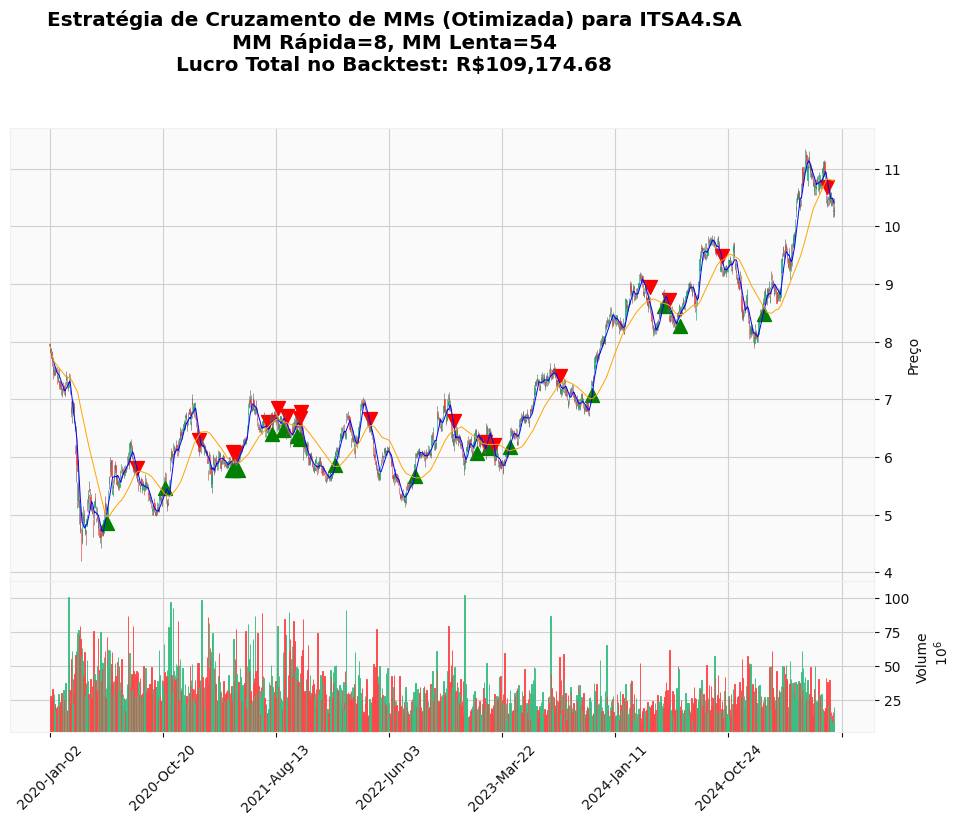


Gerando gráfico de progresso do Algoritmo Genético...


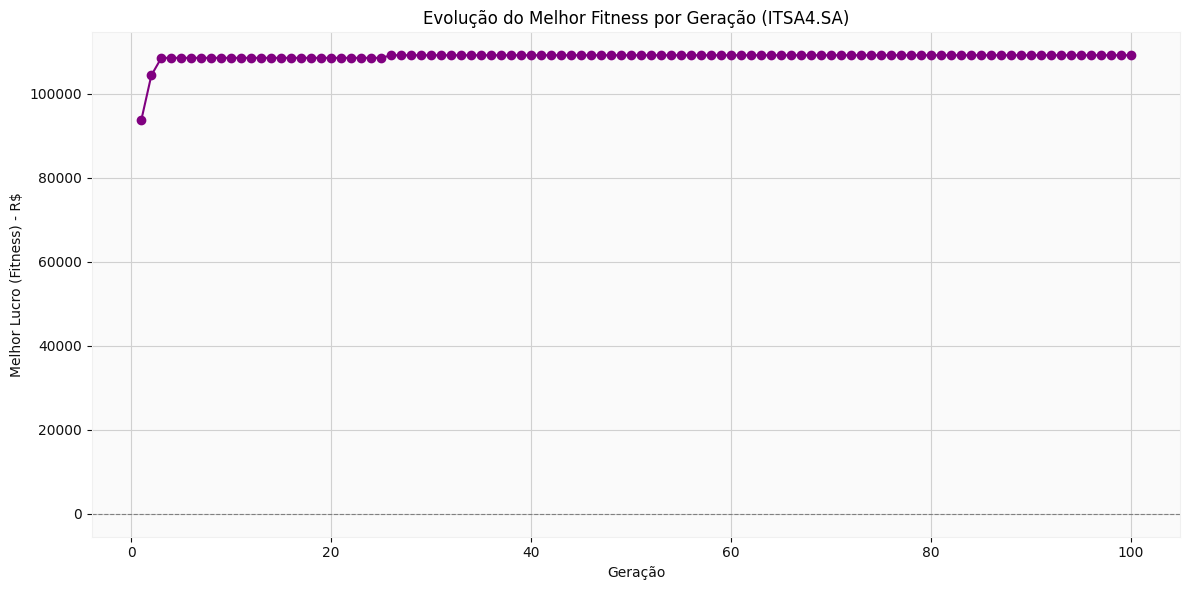


Capital Final Total (Capital Inicial + Lucro Otimizado): R\$209,174.68

ETAPA 5 CONCLUÍDA: Gráficos de resultados gerados com sucesso!

--- FIM DO SCRIPT ---


In [ ]:
# --- ETAPA 5: VISUALIZAÇÃO DOS RESULTADOS ---

print("\nETAPA 5 INICIADA: Gerando gráfico de candlestick com MMs otimizadas e sinais de negociação...")

# Recalcular as MMs para o melhor indivíduo encontrado pelo AG, usando o DataFrame de dados original
# NOTA: 'data', 'best_individual_overall' são definidos em etapas anteriores.
final_df = calculate_moving_averages(data, best_individual_overall[0], best_individual_overall[1])

# --- Gerar sinais de compra e venda para plotagem ---
# Inicializa listas para armazenar os preços dos sinais (ou NaN se não houver sinal)
buy_signals = [np.nan] * len(final_df)  # Preenche com NaN para alinhar com o DataFrame
sell_signals = [np.nan] * len(final_df) # Preenche com NaN para alinhar com o DataFrame

in_position = False # Rastreia se estamos atualmente em uma posição comprada

# Loop para identificar os pontos de sinal com base nas MMs otimizadas
for i in range(1, len(final_df)):
    # Ignora as primeiras linhas onde as MAs podem não estar totalmente calculadas (NaN)
    if pd.isna(final_df['SMA_Fast'].iloc[i]) or pd.isna(final_df['SMA_Slow'].iloc[i]) or \
       pd.isna(final_df['SMA_Fast'].iloc[i-1]) or pd.isna(final_df['SMA_Slow'].iloc[i-1]):
        continue # Pula para o próximo dia

    # Lógica de Compra: MM Rápida cruza MM Lenta de baixo para cima
    if final_df['SMA_Fast'].iloc[i-1] < final_df['SMA_Slow'].iloc[i-1] and \
       final_df['SMA_Fast'].iloc[i] > final_df['SMA_Slow'].iloc[i]:
        if not in_position: # Apenas sinaliza compra se não estiver em posição
            buy_signals[i] = final_df['Low'].iloc[i] * 0.98 # Seta um pouco abaixo do preço de fechamento
            in_position = True

    # Lógica de Venda: MM Rápida cruza MM Lenta de cima para baixo
    elif final_df['SMA_Fast'].iloc[i-1] > final_df['SMA_Slow'].iloc[i-1] and \
         final_df['SMA_Fast'].iloc[i] < final_df['SMA_Slow'].iloc[i]:
        if in_position: # Apenas sinaliza venda se estiver em posição
            sell_signals[i] = final_df['High'].iloc[i] * 1.02 # Seta um pouco acima do preço de fechamento
            in_position = False

# Preparar os dados para mplfinance
# O mplfinance espera colunas com nomes específicos: 'Open', 'High', 'Low', 'Close', 'Volume'
mpf_data = final_df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Criar uma lista de `add_plots` para incluir as MMs e os sinais no gráfico
add_plots = [
    # Adiciona a Média Móvel Rápida ao painel principal (panel=0)
    mpf.make_addplot(final_df['SMA_Fast'], color='blue', panel=0, width=0.7,
                     ylabel=f'SMA Rápida ({best_individual_overall[0]})'),
    # Adiciona a Média Móvel Lenta ao painel principal
    mpf.make_addplot(final_df['SMA_Slow'], color='orange', panel=0, width=0.7,
                     ylabel=f'SMA Lenta ({best_individual_overall[1]})'),

    # Adiciona os sinais de Compra como setas para cima (triângulos verdes)
    mpf.make_addplot(pd.Series(buy_signals, index=final_df.index),
                     type='scatter', marker='^', markersize=100, color='green', panel=0),
    # Adiciona os sinais de Venda como setas para baixo (triângulos vermelhos)
    mpf.make_addplot(pd.Series(sell_signals, index=final_df.index),
                     type='scatter', marker='v', markersize=100, color='red', panel=0)
]

# Plotar o gráfico de candlestick com as MMs e os sinais
fig, axes = mpf.plot(mpf_data,
                     type='candle',        # Tipo de gráfico: candlestick
                     style='yahoo',        # Estilo visual (ex: 'yahoo', 'binance', 'charles')
                     title=(f"Estratégia de Cruzamento de MMs (Otimizada) para {TICKER}\n"
                            f"MM Rápida={best_individual_overall[0]}, MM Lenta={best_individual_overall[1]}\n"
                            f"Lucro Total no Backtest: R\${best_fitness_overall:,.2f}"), # Título principal
                     ylabel='Preço',       # Rótulo do eixo Y do painel superior
                     ylabel_lower='Volume',# Rótulo do eixo Y do painel de volume
                     figscale=1.5,         # Escala da figura (aumenta o tamanho do gráfico)
                     addplot=add_plots,    # Adiciona as MMs e os sinais
                     panel_ratios=(3, 1),  # Proporção dos painéis (preço:volume = 3:1)
                     volume=True,          # Exibe o volume
                     returnfig=True)       # Retorna a figura e os eixos para ajustes manuais (se necessário)

# Ajustes finais para a exibição do título (para evitar que fique muito apertado)
axes[0].set_title(axes[0].get_title(), loc='center', wrap=True, fontsize=14)

plt.show() # Exibe o gráfico


# NOVO GRÁFICO: Progresso do Algoritmo Genético
print("\nGerando gráfico de progresso do Algoritmo Genético...")
plt.figure(figsize=(12, 6))
# 'best_fitness_per_generation' e 'NUM_GENERATIONS' são definidos na ETAPA 4.
plt.plot(range(1, NUM_GENERATIONS + 1), best_fitness_per_generation, marker='o', linestyle='-', color='purple')
plt.title(f'Evolução do Melhor Fitness por Geração ({TICKER})')
plt.xlabel('Geração')
plt.ylabel('Melhor Lucro (Fitness) - R\$')
plt.grid(True)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8) # Linha para indicar lucro zero
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

print("\nETAPA 5 CONCLUÍDA: Gráficos de resultados gerados com sucesso!")
print("\n--- FIM DO SCRIPT ---")